### Import Packages

In [1]:
import pickle
# from ident import Ident

from gekko import GEKKO
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Import Data

In [2]:
with open('models_05.pkl', 'rb') as file:    #model 5: max na nb nk is 3.  good to same . #model 4: this is max 3 for na and nb except {}. This is max nk 3. CP and D50 nk=1. sump level 9% off. all others 2% or less in testing.
    models = pickle.load(file)
    
df_5=pd.read_excel('D50_data_add.xlsx',header=0,index_col=0)

df_5.drop(columns=['minute'], inplace=True) #drop time

df_5['D50C']=df_5['D50C'].clip(upper=0.5) # Filter D50 data that is bad calculation

df_5.columns = [ 'F', 'FW', 'MS', 'PS', 'SW', 'BP', 'P', 'SL', 'D', 'CP', 'D50']
df_5.head()

# df[['RW']] = df[['CW']].to_numpy() - df[['IW']].to_numpy() - df[['SW']].to_numpy()

,F,FW,MS,PS,SW,BP,P,SL,D,CP,D50
0,102.462509,15.509874,15.160000,525.208252,50.587109,6104.048340,2151.0,40.304512,54.255432,11.241975,0.117296
1,103.333893,16.375196,15.160000,529.151917,54.062538,6108.159180,2155.0,43.349667,54.202900,11.241036,0.117299
2,103.808968,16.706270,15.160000,527.527954,43.480278,6085.975586,2160.0,46.226486,54.150364,11.240097,0.117301
3,102.219231,17.050024,15.156041,520.946472,37.862888,6116.854980,2153.0,38.813515,54.099995,11.239159,0.117303
4,102.523087,16.613831,15.150989,520.562073,38.544147,6100.854492,2162.0,34.497410,54.051334,11.238220,0.117305


In [9]:
df=df_5.copy()

In [3]:
# model = models['D']
# na = model.na_best
# nb = model.nb_best
# nk = model.nk_best
# n = max(na, nb, nk)
#max is 3.

In [4]:
# sl[P:] = sl_past
# cw[P:] = cw_past
# cs[P:] = cs_past
# d[P:] = d_past
# cp[P:] = cp_past
# l[P:] = l_past
# p[P:] = p_past
# rw[P:] = rw_past
# g[P:] = g_past
# what is this?  ?

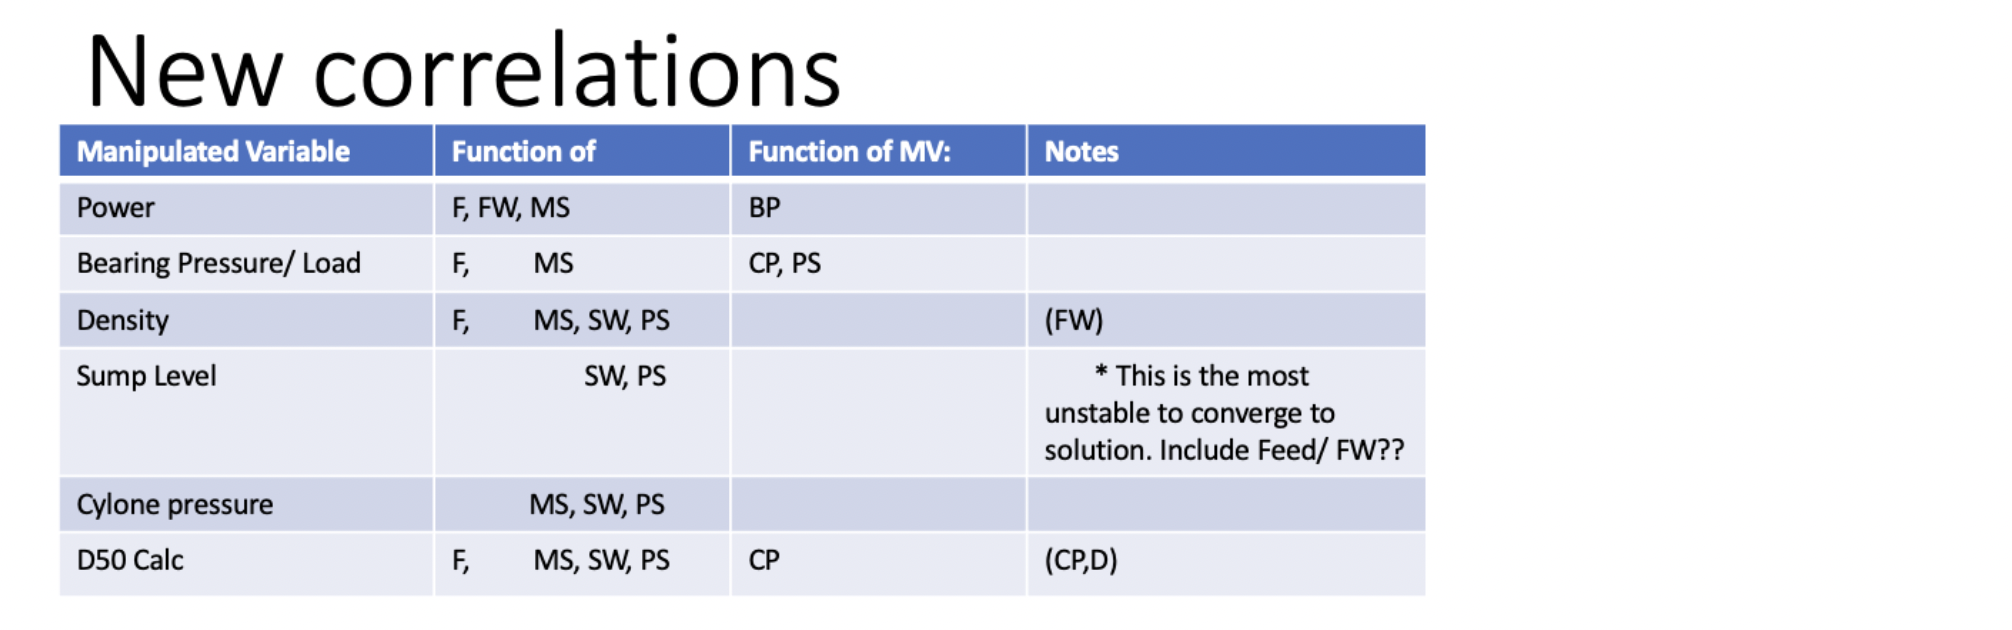

### Create MPC Controller/Model

In [7]:
class Cont(GEKKO):
    def __init__(self, P=1, M=1, n_max=10, p0=20, *args, **kwargs):       # change these inputs? ?  ?
        self.P = P 
        self.M = M
        self.MVs = [ 'F', 'FW', 'MS', 'PS', 'SW']
        self.CVs = ['BP','P', 'SL', 'D', 'CP', 'D50']
        # self.CVs = ['CS', 'CW', 'P', 'L', 'SL', 'CP', 'D']

        self.mv_result = {}
        self.cv_result = {}
        
        super().__init__(remote=False, *args, **kwargs)
        P = self.P
        M = self.M

        p0 = p0
        n_max = n_max
        
        cv_dict = {}
        mv_dict = {}

        for cv_i in self.CVs:
            cv_dict[cv_i] = np.append(self.Array(self.CV, P), self.Array(self.Param, n_max))
            self.cv_result[cv_i] = []
            
        #cv_dict['RW'] = np.append(self.Array(self.CV, P), self.Array(self.Param, n_max))     delete
            
        for mv_i in self.MVs:
            self.mv_result[mv_i] = []
            try:
                mv_dict[mv_i] = np.append(self.Array(self.MV, M), self.Array(self.Param, n_max))
            except:
                mv_dict[mv_i] = self.Array(self.Param, n_max)

        for i in range(P):
            #self.Equation(cv_dict['RW'][P-i-1]==cv_dict['CW'][P-i-1]-(mv_dict['IW'][P-i-1]+mv_dict['SW'][P-i-1]))   delete

            self.Equation(cv_dict['SL'][P-i-1] == models['SL'].alpha['SL'].dot(cv_dict['SL'][P-i:P-i+models['SL'].na_best]) + 
                                       models['SL'].beta['SW'].dot(mv_dict['SW'][P-i-1+models['SL'].nk_best:P-i+models['SL'].nb_best-1+models['SL'].nk_best]) + 
                                       models['SL'].beta['PS'].dot(mv_dict['PS'][P-i-1+models['SL'].nk_best:P-i+models['SL'].nb_best-1+models['SL'].nk_best]) +
                                       models['SL'].gamma[0])

            self.Equation(cv_dict['CP'][P-i-1] == models['CP'].alpha['CP'].dot(cv_dict['CP'][P-i:P-i+models['CP'].na_best]) + 
                                       models['CP'].beta['MS'].dot(mv_dict['MS'][P-i-1+models['CP'].nk_best:P-i+models['CP'].nb_best-1+models['CP'].nk_best]) + 
                                       models['CP'].beta['SW'].dot(mv_dict['SW'][P-i-1+models['CP'].nk_best:P-i+models['CP'].nb_best-1+models['CP'].nk_best]) +
                                       models['CP'].beta['PS'].dot(mv_dict['PS'][P-i-1+models['CP'].nk_best:P-i+models['CP'].nb_best-1+models['CP'].nk_best]) + 
                                       models['CP'].gamma[0])

            self.Equation(cv_dict['D50'][P-i-1] == models['D50'].alpha['D50'].dot(cv_dict['D50'][P-i:P-i+models['D50'].na_best]) + 
                                       models['D50'].beta['F'].dot(mv_dict['F'][P-i-1+models['D50'].nk_best:P-i+models['D50'].nb_best-1+models['D50'].nk_best]) + 
                                       models['D50'].beta['SW'].dot(mv_dict['SW'][P-i-1+models['D50'].nk_best:P-i+models['D50'].nb_best-1+models['D50'].nk_best]) + 
                                       models['D50'].beta['MS'].dot(mv_dict['MS'][P-i-1+models['D50'].nk_best:P-i+models['D50'].nb_best-1+models['D50'].nk_best]) +
                                       models['D50'].beta['PS'].dot(mv_dict['PS'][P-i-1+models['D50'].nk_best:P-i+models['D50'].nb_best-1+models['D50'].nk_best]) + 
                                       models['D50'].gamma[0])

            self.Equation(cv_dict['D'][P-i-1] == models['D'].alpha['D'].dot(cv_dict['D'][P-i:P-i+models['D'].na_best]) + 
                                      models['D'].beta['F'].dot(mv_dict['F'][P-i-1+models['D'].nk_best:P-i+models['D'].nb_best-1+models['D'].nk_best]) + 
                                      models['D'].beta['SW'].dot(mv_dict['SW'][P-i-1+models['D'].nk_best:P-i+models['D'].nb_best-1+models['D'].nk_best]) + 
                                      models['D'].beta['MS'].dot(mv_dict['MS'][P-i-1+models['D'].nk_best:P-i+models['D'].nb_best-1+models['D'].nk_best]) + 
                                      models['D'].beta['PS'].dot(mv_dict['PS'][P-i-1+models['D'].nk_best:P-i+models['D'].nb_best-1+models['D'].nk_best]) + 
                                      models['D'].gamma[0])

            self.Equation(cv_dict['BP'][P-i-1]== models['BP'].alpha['BP'].dot(cv_dict['BP'][P-i:P-i+models['BP'].na_best]) + 
                                      models['BP'].beta['F'].dot(mv_dict['F'][P-i-1+models['BP'].nk_best:P-i+models['BP'].nb_best-1+models['BP'].nk_best]) + 
                                      models['BP'].beta['MS'].dot(mv_dict['MS'][P-i-1+models['BP'].nk_best:P-i+models['BP'].nb_best-1+models['BP'].nk_best]) + 
                                      models['BP'].gamma[0])

            self.Equation(cv_dict['P'][P-i-1] == models['P'].alpha['P'].dot(cv_dict['P'][P-i:P-i+models['P'].na_best]) + 
                                      models['P'].beta['FW'].dot(mv_dict['FW'][P-i-1+models['P'].nk_best:P-i+models['P'].nb_best-1+models['P'].nk_best]) + 
                                      models['P'].beta['MS'].dot(mv_dict['MS'][P-i-1+models['P'].nk_best:P-i+models['P'].nb_best-1+models['P'].nk_best]) + 
                                      models['P'].beta['F'].dot(mv_dict['F'][P-i-1+models['P'].nk_best:P-i+models['P'].nb_best-1+models['P'].nk_best]) +
                                      models['P'].gamma[0])

        self.f = mv_dict['F']
        self.fw = mv_dict['FW']
        self.ms = mv_dict['MS']
        self.ps = mv_dict['PS']
        self.sw = mv_dict['SW']
        
        self.d = cv_dict['D']
        self.bp = cv_dict['BP']
        self.p = cv_dict['P']
        self.sl = cv_dict['SL']
        self.cp = cv_dict['CP']
        self.d50 = cv_dict['D50']
        
        self.mv_dict = mv_dict
        self.cv_dict = cv_dict
        
        self.options.IMODE = 2        #IMODE ? ? ? 

        
    # def ss_run(self):
    #     self.options.IMODE = 1
    #     self.solve(disp=False)
        
    def update_model(self, mv_dict_new, cv_dict_new):
        for mv_i in self.MVs:
            for ind, val in enumerate(mv_dict_new[mv_i]):
                self.mv_dict[mv_i][ind+self.M].value = val
            
        for cv_i in self.CVs:
            for ind, val in enumerate(cv_dict_new[cv_i]):
                self.cv_dict[cv_i][ind+self.P].value = val
                
    
    def get_results(self):
        for cv_i in self.CVs:
            self.cv_result[cv_i].append(self.cv_dict[cv_i][self.P-1].value[0])
 
        for mv_i in self.MVs:
            self.mv_result[mv_i].append(self.mv_dict[mv_i][self.M-1].value[0])
        


### Setup Controller + Run Controller

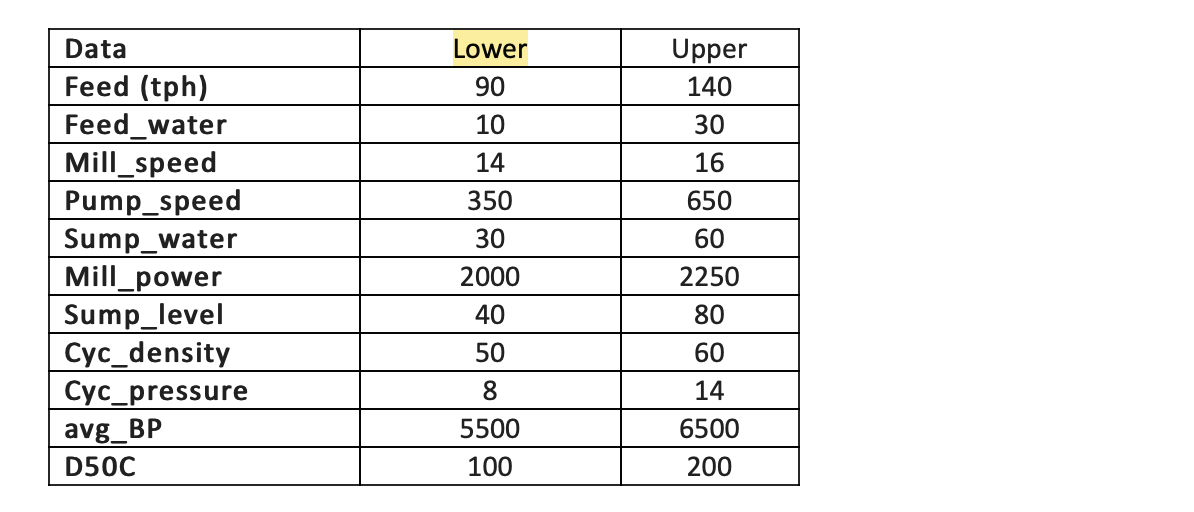

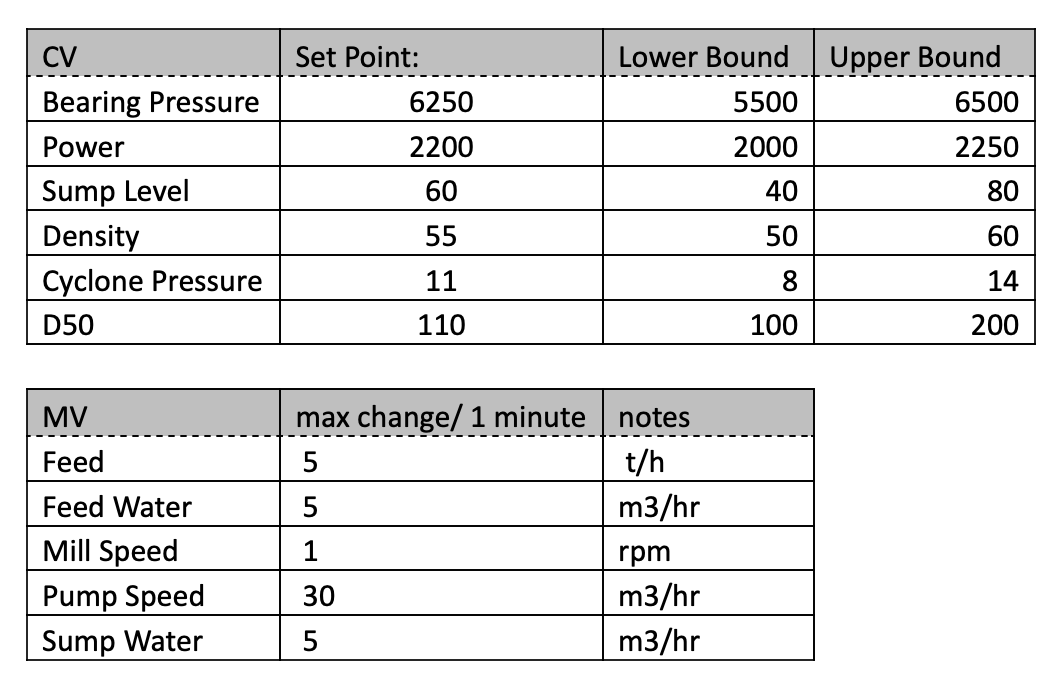

In [29]:
#Manipulated variables
MV = [ 'F', 'FW', 'MS', 'PS', 'SW']

#Controlled variables
CV = ['BP','P', 'SL', 'D', 'CP', 'D50']

P = 1 # Number of controlled variables
M = 1 # Number of manipulated variables

p0 = 20 # Initial index for controller
n_max = 10 # Number of past values to consider

mv_past = {}
cv_past = {}

#Dictionary of variable limits
lim_dict = {
# Controlled variables
'BP': [5500, 6500],
'P': [2000, 2250],
'SL': [40, 80],
'D': [50, 60],
'CP': [8, 14],
'D50': [0.1, 0.2],

# Manipulated variables
'F': [90, 140],
'FW': [10, 30],
'MS': [14, 16],
'PS': [350, 650],
'SW': [30, 60],
}

#Dictionary of desired setpoint values     # where is this used?
sp_dict = {
'BP': 6250,
'P': 2200,
'SL': 60,
'D': 55,
'CP': 11,
'D50': 0.110,
}

#Modify setpoint ranges to stay within 10% to 20% of desired setpoint    ? if want to weigh variables more for objective function
wsp_dict = {
    'BP': 0,
    'P': 0,
    'SL': 0,
    'D': 0,    # 100?  * * * change
    'CP': 0,
    'D50': 0,
}
dmax_dict={'F': 10,'FW': 10,'MS': 2,'PS': 60,'SW': 10}   #this is 1 min values doubled.   ## Dmax values for 2 min from  1


#tier_dict={'CS': 0, 'CW': 0,'P': 50,  'L': 50, 'SL': 0,'CP': 0,'D': 100,'RW': 0,'G': 20}   #rank priority

#Create Cont object
cont = Cont(P=P, M=M, n_max=n_max, p0=p0)



#Set status and limits for manipulated variables
for mv_i in MV:
    for i in range(M):
        cont.mv_dict[mv_i][i].STATUS = 1
        cont.mv_dict[mv_i][i].LOWER = lim_dict[mv_i][0]
        cont.mv_dict[mv_i][i].UPPER = lim_dict[mv_i][1]
        cont.mv_dict[mv_i][i].DMAX = dmax_dict[mv_i]     # could add DCOST in next line

#Set status, setpoint range, and setpoint values for controlled variables
for cv_i in CV:
    for i in range(P):
#         if (cv_i == 'CW') or (cv_i == 'CS') or (cv_i == 'RW'):     # add one here? because skinny?
#             cont.cv_dict[cv_i][i].SPLO = None
#             cont.cv_dict[cv_i][i].SPHI = None
#         else:
        cont.cv_dict[cv_i][i].STATUS = 1
        cont.cv_dict[cv_i][i].SPLO = lim_dict[cv_i][0]
        cont.cv_dict[cv_i][i].SPHI = lim_dict[cv_i][1]
        cont.cv_dict[cv_i][i].WSP = wsp_dict[cv_i]
        #cont.cv_dict[cv_i][i].TIER = tier_dict[cv_i]
        cont.cv_dict[cv_i][i].SP = sp_dict[cv_i]       #(lim_dict[cv_i][0] + lim_dict[cv_i][1])/2     original
            
# for i in range(n_max):
#     cont.cv_dict['RW'][P+i].value = cont.cv_dict['RW'][P+i].value - (cont.mv_dict['IW'][P+i].value+cont.mv_dict['SW'][P+i].value)        

cont.options.IMODE = 3 #go to 6 or 9
# cont.options.SOLVER = 2
cont.CV_TYPE = 1

# cont.Minimize(sum(abs(cont.sl-66)))
# cont.ss_run()
run_steps = 600
yp = []

for k in range(run_steps):
    if k == 0: 
        for mv_i in MV:
            mv_past[mv_i] = df[[mv_i]].iloc[p0+k:p0-n_max+k:-1].to_numpy().flatten()
        for cv_i in CV:
            cv_past[cv_i] = df[[cv_i]].iloc[p0+k-1:p0-n_max+k-1:-1].to_numpy().flatten()
    else:
        for mv_i in MV:
            mv_past[mv_i] = [val.value[0] for val in cont.mv_dict[mv_i][M-1:n_max+M-1]]
        for cv_i in CV:
            cv_past[cv_i] = [val.value[0] for val in cont.cv_dict[cv_i][P-1:n_max+P-1]]

    cont.update_model(mv_past, cv_past)
    
    # for mv_i in MV:
    #     for i in range(M):
    #         cont.mv_dict[mv_i][i].value = cont.mv_dict[mv_i][M].value
    # if k == 300:
    #     cont.cv_dict['G'][0].SP = 45.0
    #     cont.cv_dict['G'][0].SPLO = 44.8
    #     cont.cv_dict['G'][0].SP = 45.2
    cont.solve(disp=False)
#     if cont.options.APPINFO!=0:
#         print('Solver error, looking at APPINFO')
#     if cont.options.APPINFO==1:
#         print('APPINFO=1')
#     elif cont.options.APPINFO==2:
#         print('APPINFO=2')
    
    cont.get_results()
    
    cont.clear_data()


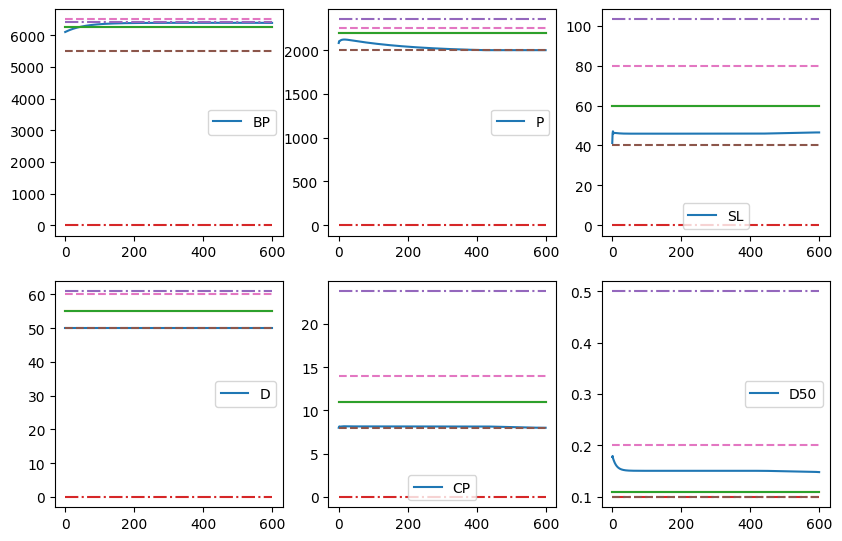

In [31]:
plt.figure(figsize=(10,10))

for ind, cv_i in enumerate(CV):
#     if cv_i == 'RW':
#         continue         #if skip
    plt.subplot(3,3,ind+1)
    plt.plot(cont.cv_result[cv_i], label=cv_i)
    try:
        plt.plot([0, len(cont.cv_result[cv_i])], [cont.cv_dict[cv_i][0].SP, cont.cv_dict[cv_i][0].SP])
        plt.plot([0, len(cont.cv_result[cv_i])], [cont.cv_dict[cv_i][0].SP, cont.cv_dict[cv_i][0].SP])

    except:
        pass
    plt.plot([0, len(cont.cv_result[cv_i])], [df[cv_i].min(), df[cv_i].min()], '-.')
    plt.plot([0, len(cont.cv_result[cv_i])], [df[cv_i].max(), df[cv_i].max()], '-.')
    
    plt.plot([0, len(cont.cv_result[cv_i])], [cont.cv_dict[cv_i][0].SPLO, cont.cv_dict[cv_i][0].SPLO], '--')
    plt.plot([0, len(cont.cv_result[cv_i])], [cont.cv_dict[cv_i][0].SPHI, cont.cv_dict[cv_i][0].SPHI], '--')
    
    plt.legend()
    
plt.show()

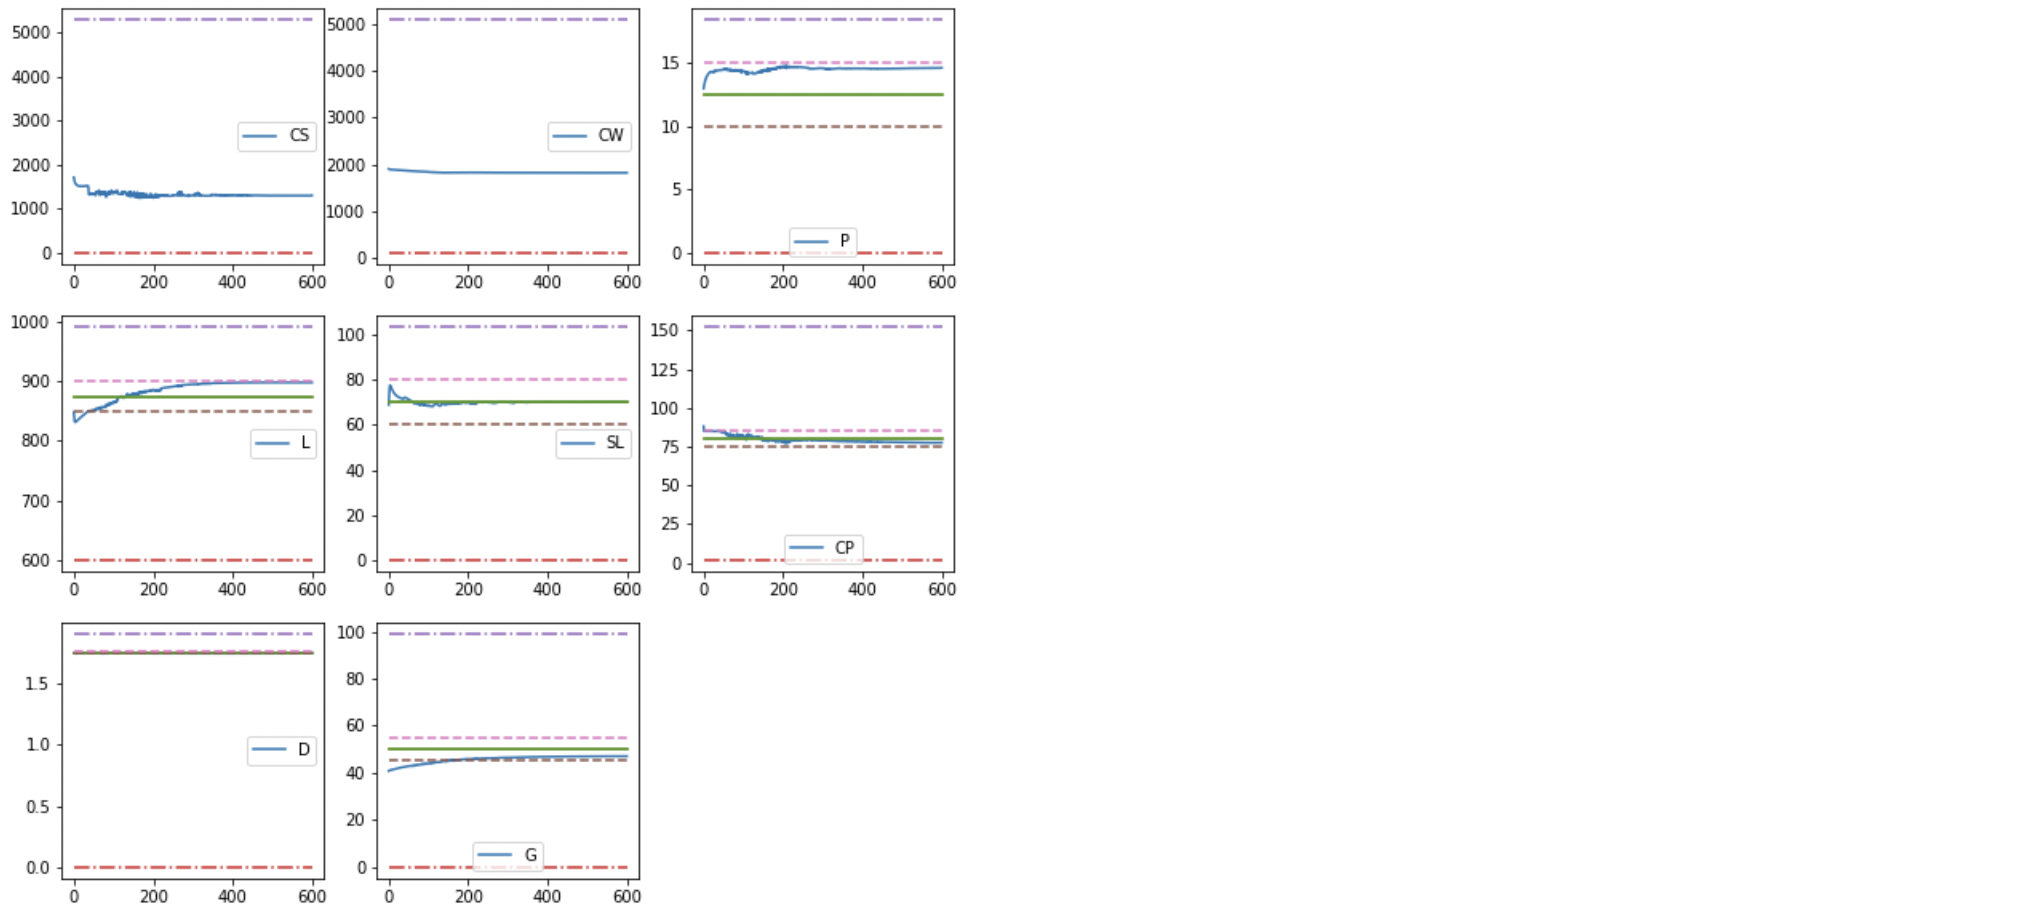

In [16]:
# cont.cv_dict['D'][0].SP = 1.75
# cont.cv_dict['CP'][0].SP = 70
# ? dont need this i think

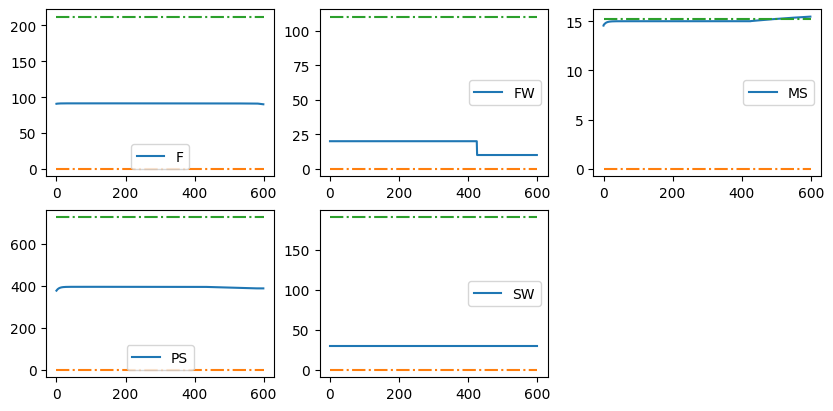

In [32]:
plt.figure(figsize=(10,10))

for ind, mv_i in enumerate(MV):
    plt.subplot(4,3,ind+1)
    plt.plot(cont.mv_result[mv_i], label=mv_i)
    # plt.plot([0, len(cont.mv_result[mv_i])], [df[mv_i].mean(), df[mv_i].mean()])
    
    plt.plot([0, len(cont.mv_result[mv_i])], [df[mv_i].min(), df[mv_i].min()], '-.')
    plt.plot([0, len(cont.mv_result[mv_i])], [df[mv_i].max(), df[mv_i].max()], '-.')

    # plt.plot([0, len(cont.mv_result[mv_i])], [cont.mv_dict[mv_i][0].LOWER, cont.mv_dict[mv_i][0].LOWER], '--')
    # plt.plot([0, len(cont.mv_result[mv_i])], [cont.mv_dict[mv_i][0].UPPER, cont.mv_dict[mv_i][0].UPPER], '--')
    plt.legend()
plt.show()

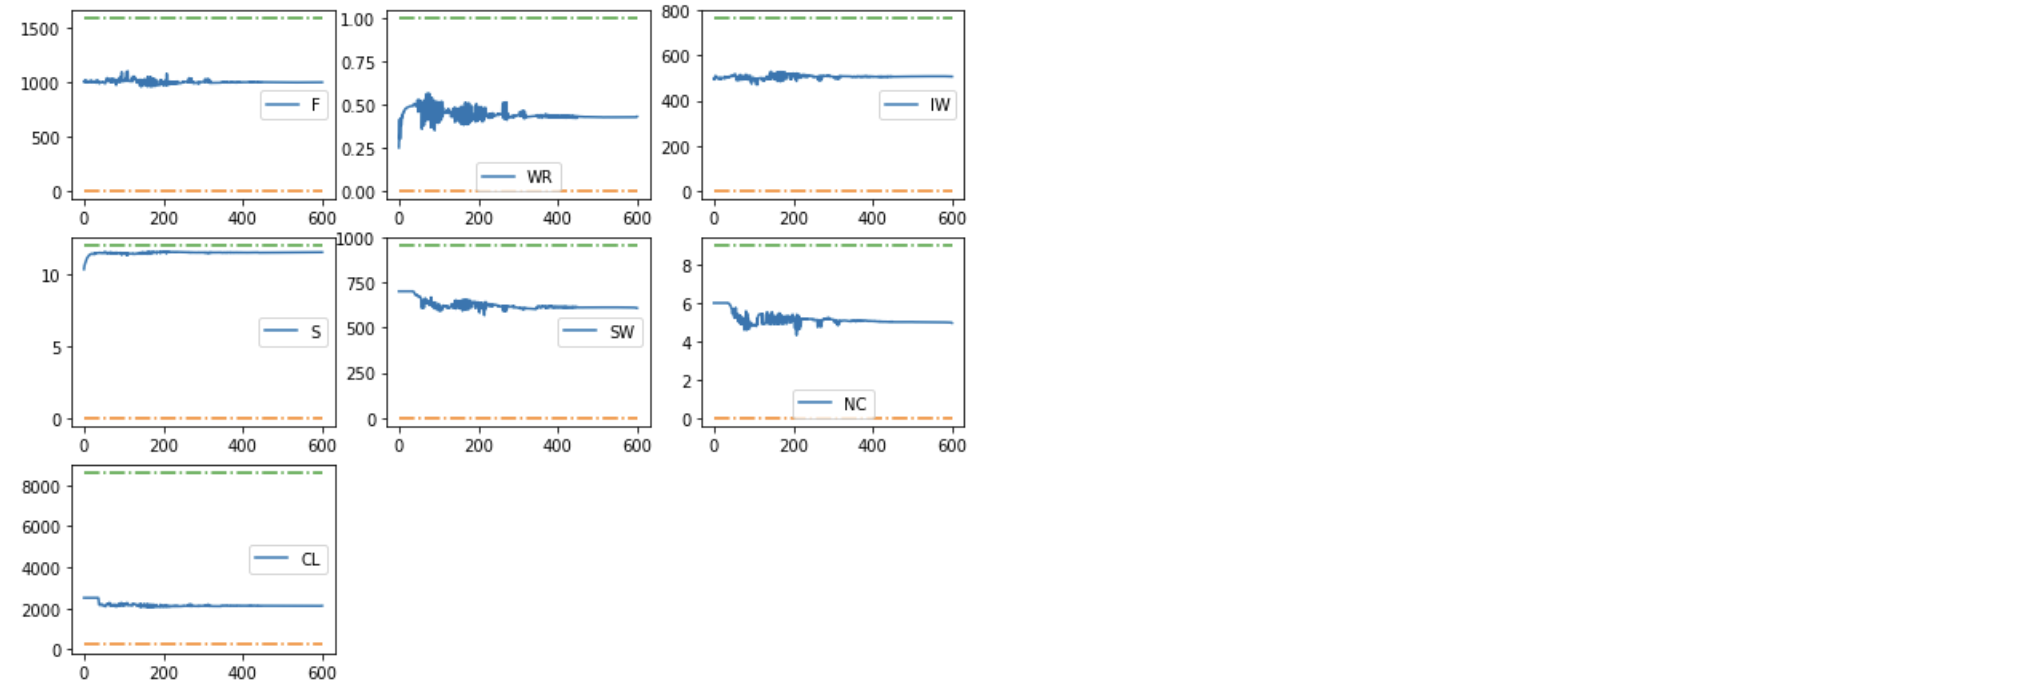

In [23]:
#cont.mv_result['NC']

In [68]:
#cont.cv_dict['P'][0].SP


12.5

In [64]:
#cont.cv_dict['G'][0]

[47.006777378]

In [65]:
with open('results.pkl', 'wb') as file:
    pickle.dump([cont.mv_result, cont.cv_result, cont.mv_dict, cont.cv_dict, df], file)

In [67]:
plt.savefig("my_figure.png")

<Figure size 432x288 with 0 Axes>